In [8]:
from scipy.io import wavfile as WF

import numpy as np

from scipy.signal import * 
import matplotlib.pyplot as plt

In [17]:
def thirdoct(rate, k, n_bands, mn):
    freqs = np.linspace(0, rate, k + 1)
    freqs = freqs[0:(k/2 + 1)]
    q = np.arange(n_bands)
    cf = np.power(2, q/3.) * mn
    fl = np.sqrt((np.power(2., q/3.) * mn) * (np.power(2., (q - 1.)/3.) * mn))
    fr = np.sqrt((np.power(2., q/3.) * mn) * (np.power(2., (q + 1.)/3.) * mn))
    A = np.zeros((n_bands, freqs.shape[0]))
    print(A.shape)
    #for i in range(cf.shape[0]):
        
                    
thirdoct(16000, 512, 15, 150)

(15, 257)


/home/lextal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


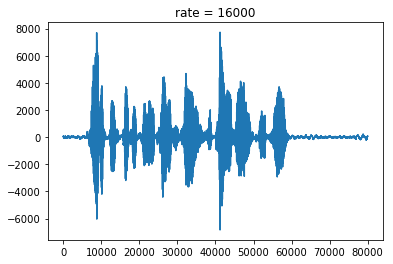

In [7]:
rate, data = WF.read('sound.wav')
plt.plot(data)
plt.title('rate = {}'.format(rate))
plt.show()

In [ ]:
n_frame = 256 # window
k = 512 # fft size
n_bands = 15
cf = 150 # center frequency of first 1/3 octave band in Hz
H = thirdoct(rate, k, n_bands, cf) #1/3 octave band matrix